#### Sanitizing dataset using KNN
Start with raw data set, resize to 60x60, run KNN algorithm, and identify the indices of train datapoints classified correctly.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import pickle5 as pickle
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage.transform import resize as sk_resize

from scipy import ndimage
import cv2

from helpers import *

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

##### Unfiltered data

In [2]:
# load data
with open('WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)
print(f'Unfiltered data shape: {raw_data.shape}')
raw_data.head()

Unfiltered data shape: (172950, 11)


,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train


In [3]:
# add index column to identify specific wafers 
raw_data.reset_index(inplace=True)
raw_data = raw_data.rename(columns={'index':'ID'})

# add detection model labels
raw_data['detectLabels'] = raw_data['failureType'].apply(lambda x: 0 if x == 'none' else 1)

# add classification model labels
fail_dict = {'none': 8, 'Loc': 0, 'Edge-Loc': 1, 'Center': 2, 'Edge-Ring': 3, 
             'Scratch': 4, 'Random': 5, 'Near-full': 6, 'Donut': 7}
raw_data['classifyLabels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])

raw_data.head()

,ID,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detectLabels,classifyLabels
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8


In [4]:
# prepare data for knn model
# keep only train set
data = raw_data[raw_data.dataset == 'train'].reset_index(drop=True)

# remove nones
df = data[data['classifyLabels'] != 8].reset_index(drop=True)
print(f'Shape with nones removed: {df.shape}')

# resize images to 60x60
df['waferMap60'] = df.waferMap.apply(lambda x: sk_resize(x, [60,60], order=0, preserve_range=True, anti_aliasing=False))

# flatten images
df['waferMapFlat'] = df.waferMap60.apply(lambda x: x.flatten())

# create model inputs
train_data = np.stack(df['waferMapFlat'].to_numpy())
train_labels  = df['classifyLabels'].to_numpy()

Shape with nones removed: (17863, 14)


Per Label Metrics for KNN Model:
   Precision  Recall  F1-Score
0    0.55      0.87     0.67  
1    0.88      0.72     0.79  
2    0.90      0.88     0.89  
3    0.98      0.97     0.97  
4    0.68      0.35     0.46  
5    1.00      0.54     0.70  
6    0.69      0.99     0.81  
7    0.96      0.71     0.82  

Model accuracy for k = 3: 0.84140401948161


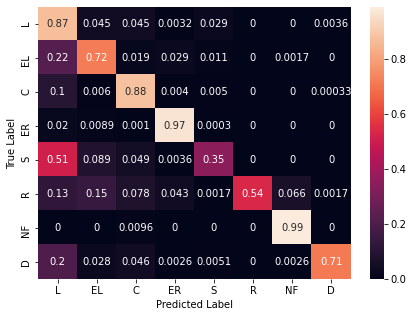

In [5]:
classifier = KNeighborsClassifier(n_neighbors=3)
        
# train on mini train set
trained_classifier = classifier.fit(train_data, train_labels)

# evaluate performance on train set and generate report
y_predict = trained_classifier.predict(train_data)
report = classification_report(train_labels, y_predict, output_dict=True)

# show precision, recall, and F1 for each label for 1-NN
digits = ['0', '1', '2', '3', '4', '5', '6', '7']

print("Per Label Metrics for KNN Model:")
print("   Precision  Recall  F1-Score")

for key in report.keys():
    if key in digits:
        print(key, end="  ")
        print(f"{report[key]['precision']:^9.2f}", end="  ")
        print(f"{report[key]['recall']:^6.2f}", end="  ")
        print(f"{report[key]['f1-score']:^8.2f}")

print()

# show accuracy for each k-NN model
print(f"Model accuracy for k = 3:", report['accuracy'])

plot_confusion_matrix(train_labels, y_predict)

In [6]:
# figure out train set indices of correctly classified points

# step 1: figure out indices of correctly classified points in df (train set minus nones)
correct_df = np.where(y_predict == train_labels)
print(f'Sanity check: {len(correct_df[0])/len(train_labels)}')
test_index = correct_df[0][424]
print(f'{train_labels[test_index]}, {y_predict[test_index]}')

# step 2: figure out IDs of correctly classified points
correct_ids = [df['ID'][i] for i in correct_df[0]]

# step 3: figure out indices of correctly classified points in data (train set)
correct_indices = [data.index[data.ID == i][0] for i in correct_ids]

Sanity check: 0.84140401948161
3, 3


In [7]:
# save IDs for use to filter later
with open(f'knn_sanitize_ids.pkl', "wb") as f:
    pickle.dump(correct_ids, f)

In [8]:
# create knn sanitized raw dataset
knn_data = data.loc[correct_indices].reset_index(drop=True)
print(knn_data.shape)
knn_data.head()

(15030, 14)


,ID,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detectLabels,classifyLabels
0,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,Edge-Loc,3,53,58,"(53, 58)","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,1,1
1,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,Edge-Loc,3,53,58,"(53, 58)","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,1,1
2,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,Edge-Loc,3,53,58,"(53, 58)","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,1,1
3,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,16.0,Loc,5,53,58,"(53, 58)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",train,1,0
4,43,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,20.0,Center,4,53,58,"(53, 58)","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,1,2


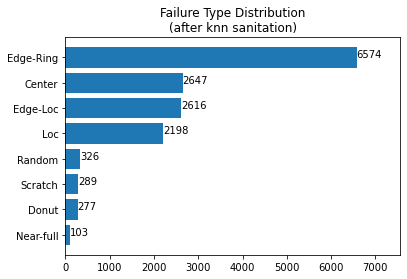

In [9]:
defect_distribution(knn_data, note='after knn sanitation')